In [282]:
import torch 
from stimulus import *
from BIRNN import *
import matplotlib.pyplot as plt 
from tqdm import trange

%matplotlib inline
memory_size = 128
in_emb = memory_size//4
mem_lay = 1
inputs_dim = 2
decisions = 3
dt = .1

typeCell = 'GRU'

sensor = ResMLP(inputs_dim, in_emb, [64,64,64])
actor = ResMLP(memory_size, decisions, [64,64,64])

GRUm = SenseMemAct(sensor, actor, in_sz=in_emb, mem_sz=memory_size, 
                    mem_lay=mem_lay, decisions=decisions, type = typeCell)
modelfname = f'./results_train/checkpoint_{typeCell}.pth'
state = torch.load(modelfname, map_location=torch.device('cpu'))
GRUm.load_state_dict(state)

typeCell = 'BRC'

sensor = ResMLP(inputs_dim, in_emb, [64,64,64])
actor = ResMLP(memory_size, decisions, [64,64,64])

BRCm = SenseMemAct(sensor, actor, in_sz=in_emb, mem_sz=memory_size, 
                    mem_lay=mem_lay, decisions=decisions, type = typeCell)
modelfname = f'./results_train/checkpoint_{typeCell}.pth'
state = torch.load(modelfname, map_location=torch.device('cpu'))
BRCm.load_state_dict(state)

typeCell = 'BEF'

sensor = ResMLP(inputs_dim, in_emb, [64,64,64])
actor = ResMLP(memory_size, decisions, [64,64,64])

BEFm = SenseMemAct(sensor, actor, in_sz=in_emb, mem_sz=memory_size, 
                    mem_lay=mem_lay, decisions=decisions, type = typeCell)
modelfname = f'./results_train/checkpoint_{typeCell}.pth'
state = torch.load(modelfname, map_location=torch.device('cpu'))
BEFm.load_state_dict(state)

<All keys matched successfully>

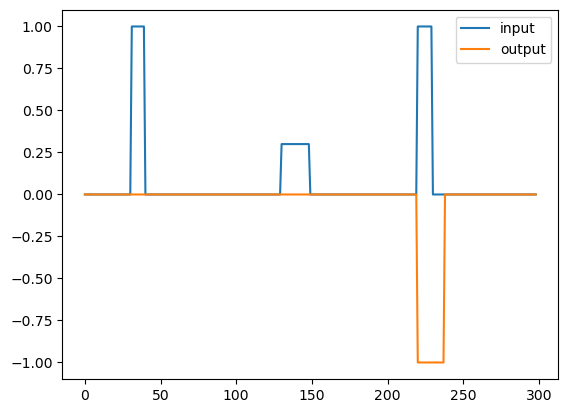

In [322]:
stimG = StimGenerator(dt=.1)
d_i, d_o = stimG.get_batch_data(1)
d_i, d_o = stimG.extend_sim(30, d_i, d_o)

plt.plot(d_i[0], label = 'input')
plt.plot(d_o[0], label = 'output')
plt.legend()
plt.show()

# plt.plot(d_i[1], label = 'input')
# plt.plot(d_o[1], label = 'output')
# plt.legend()
# plt.show()

B, L = d_i.shape
mod_in = torch.zeros((B,L,2))
mod_in[...,0][d_i == 1] = 1
mod_in[...,1][d_i != 1] = d_i[d_i!=1]

In [323]:
with torch.no_grad():
    _,GRUmem = GRUm(mod_in, mem = True)
    _,BRCmem = BRCm(mod_in, mem = True)
    _,_,_,_,_,BEFmemf,BEFmems = BEFm(mod_in, debug_mem = True)

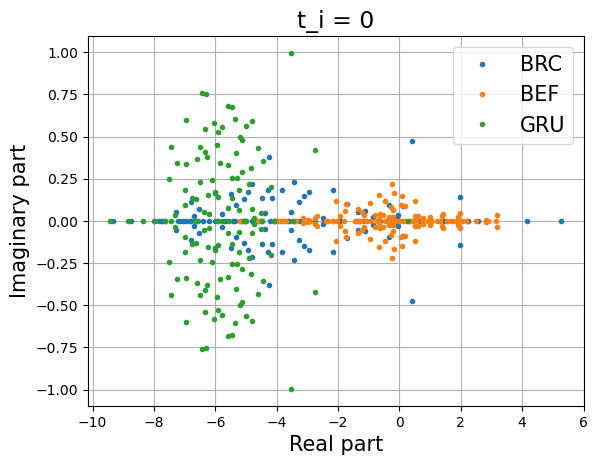

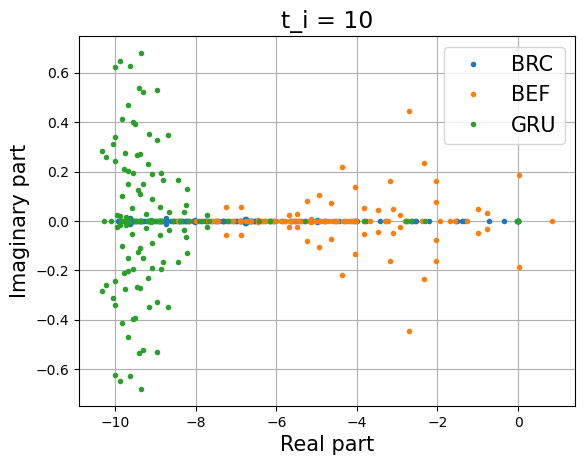

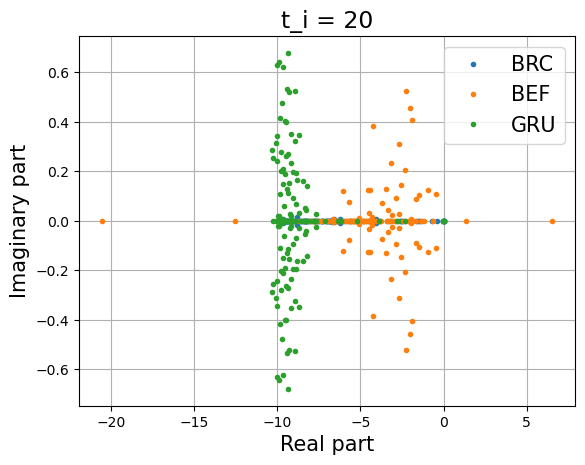

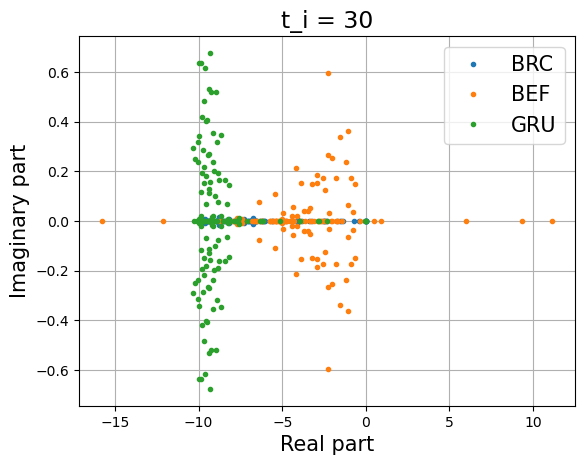

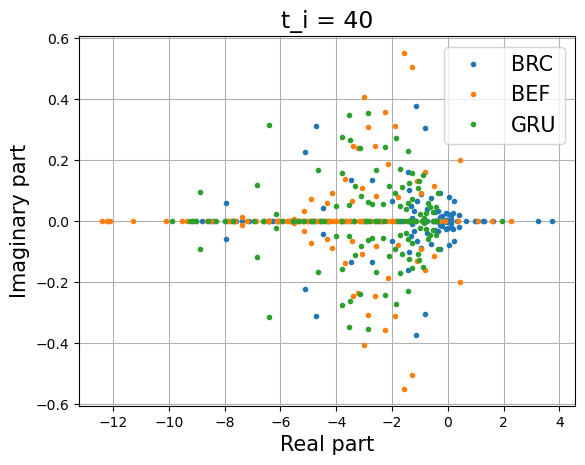

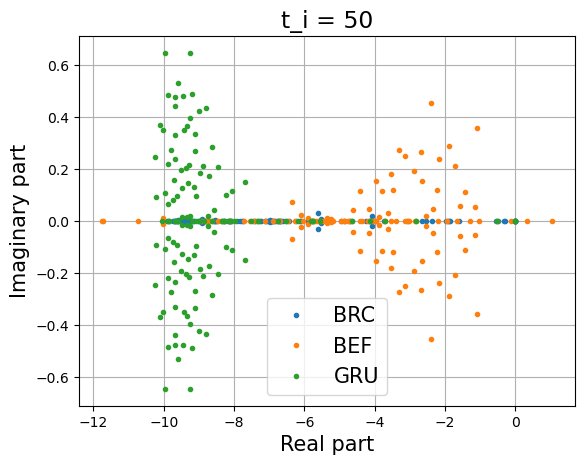

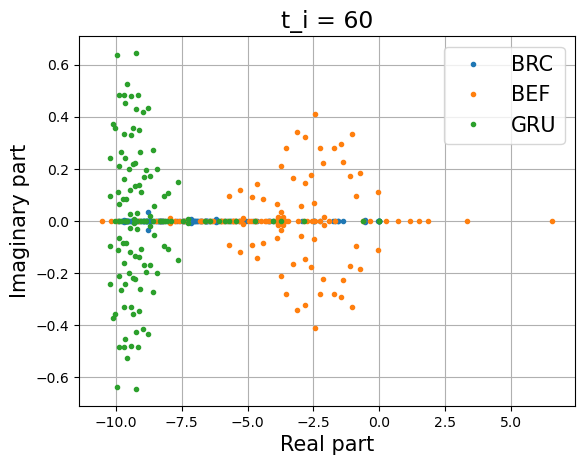

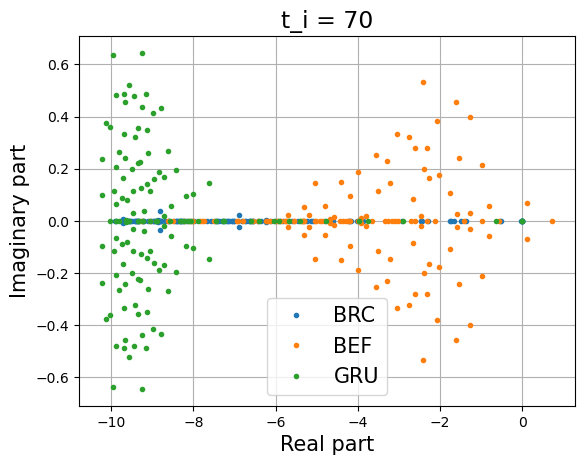

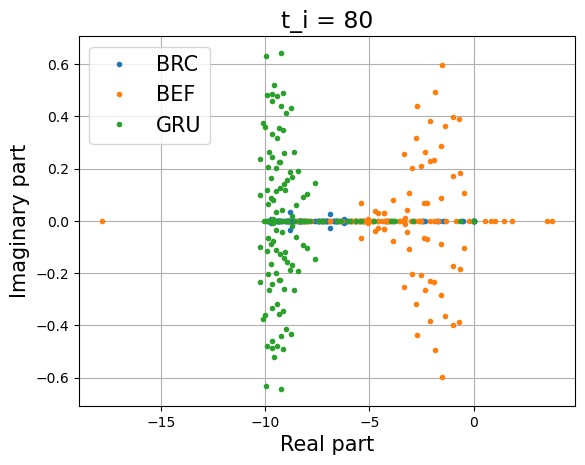

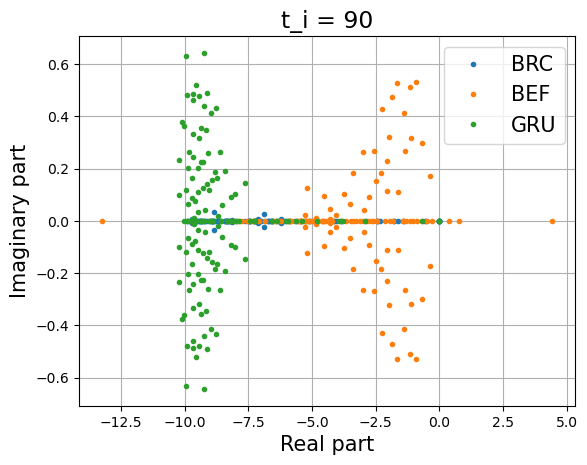

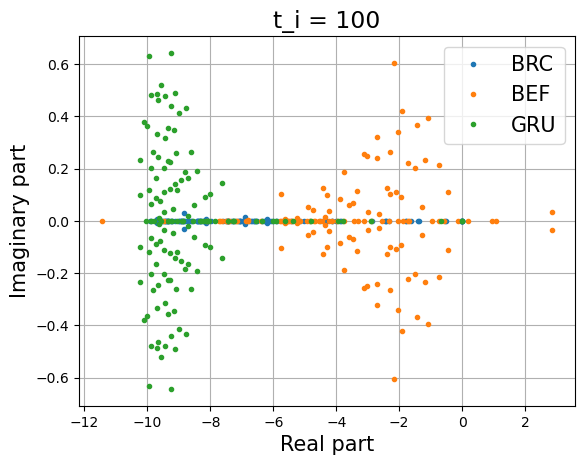

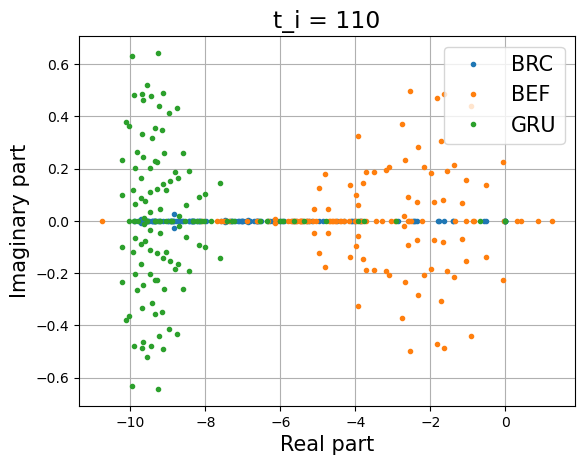

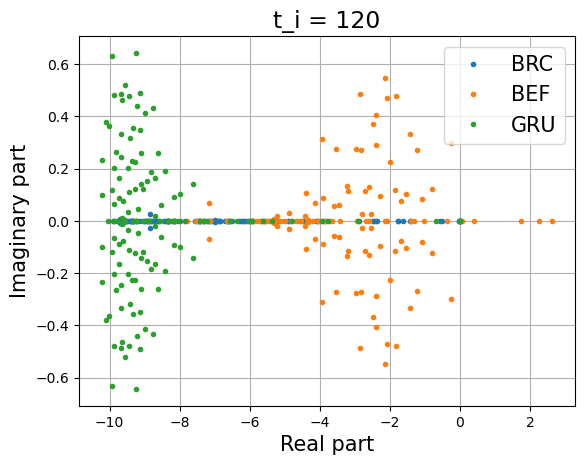

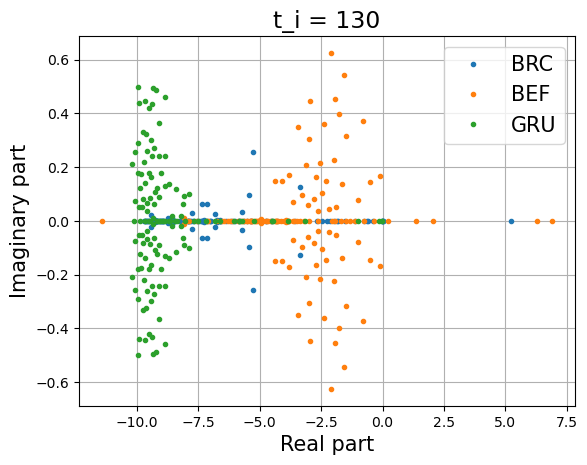

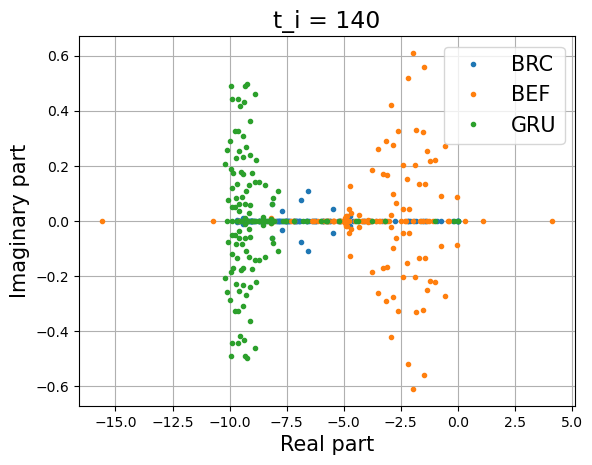

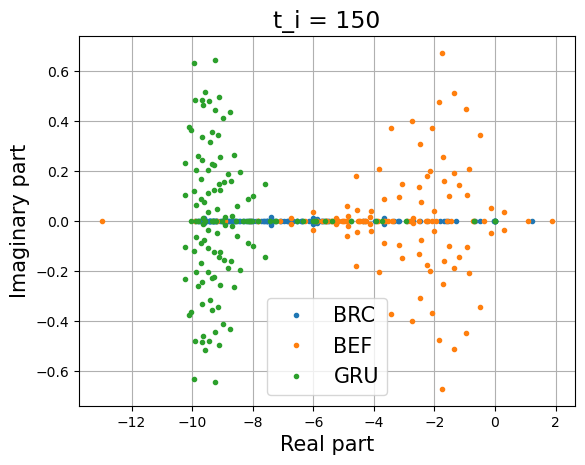

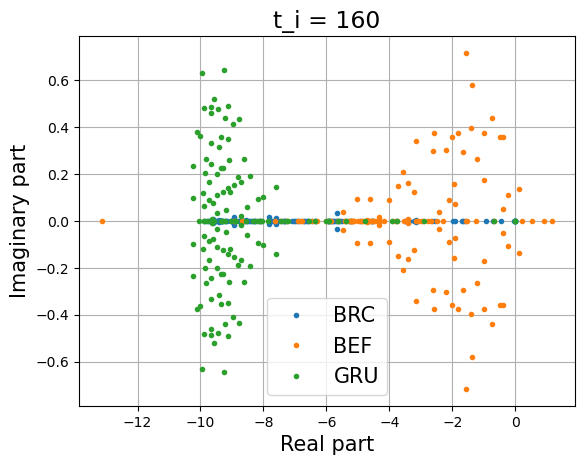

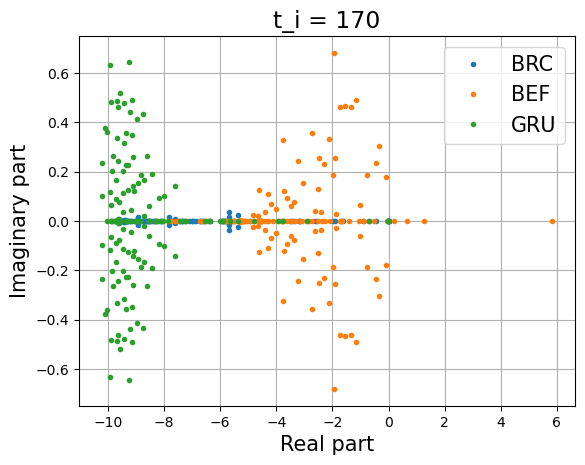

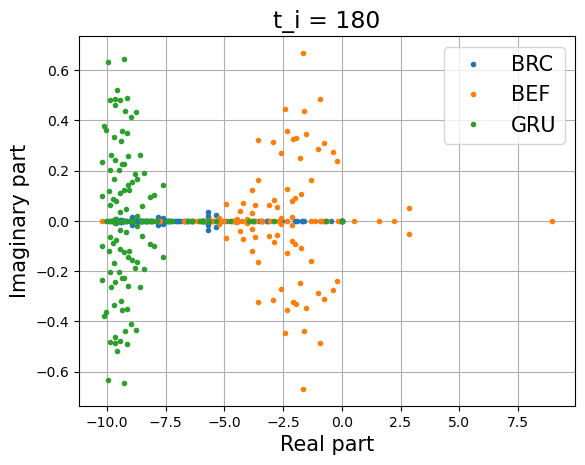

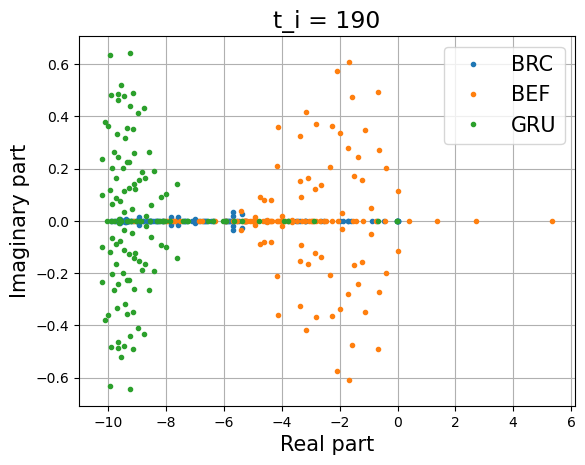

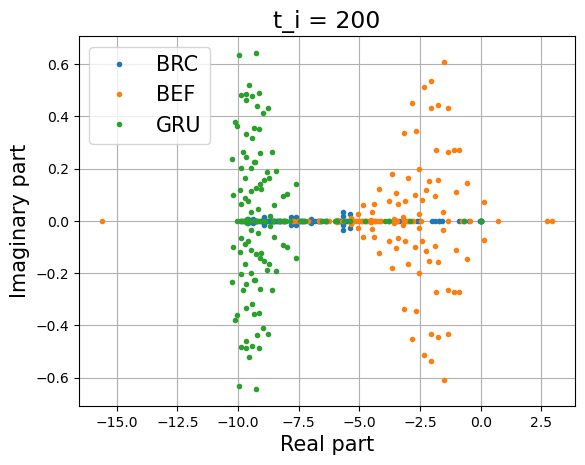

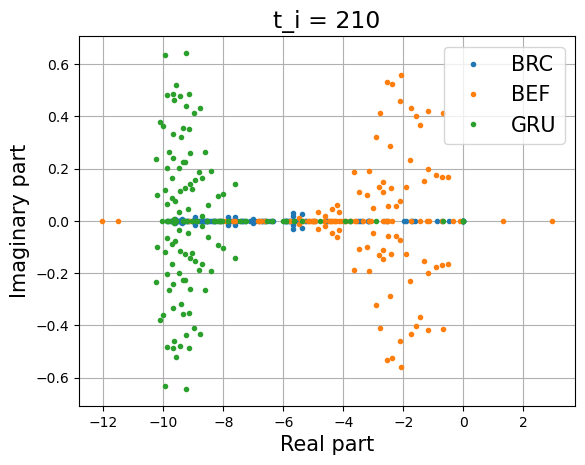

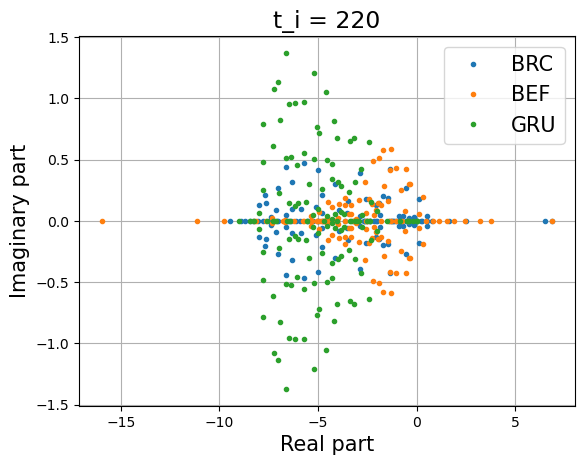

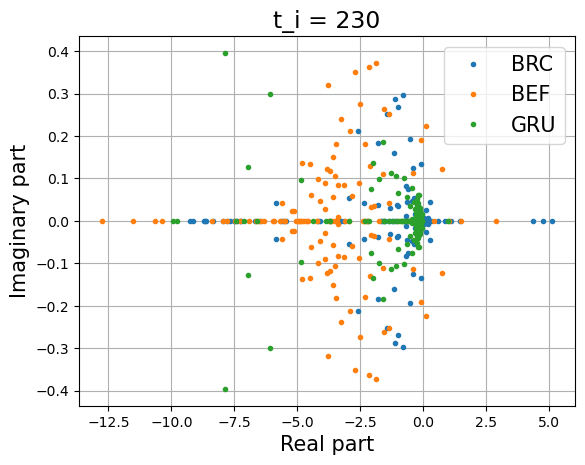

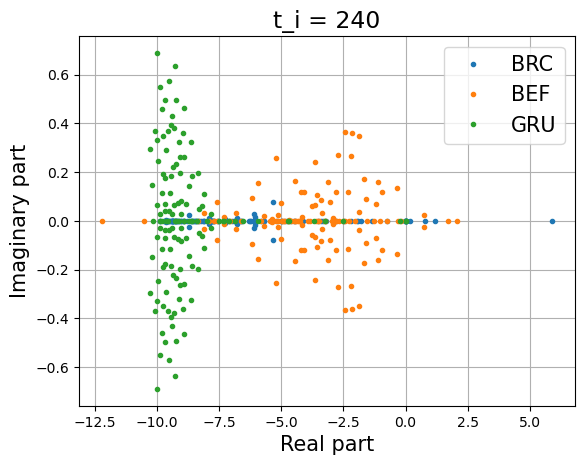

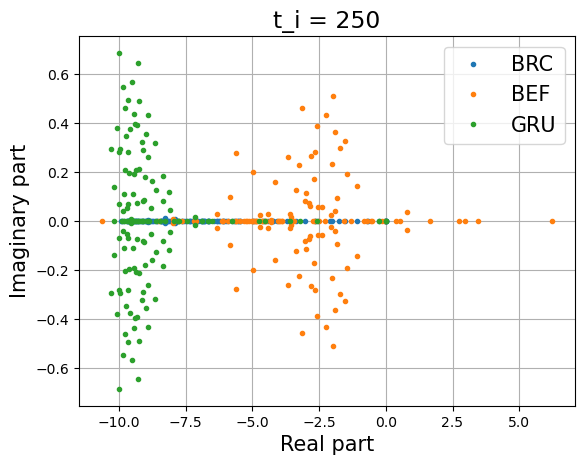

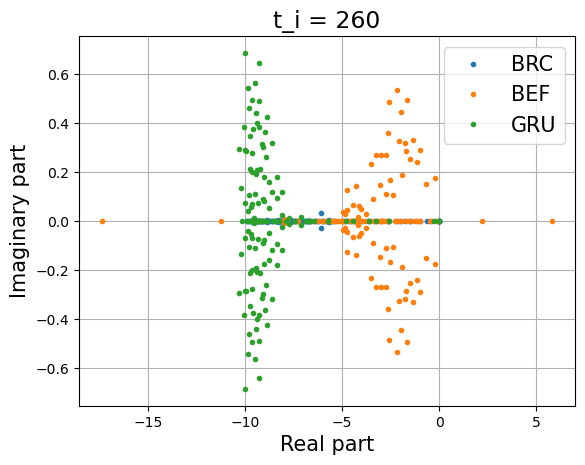

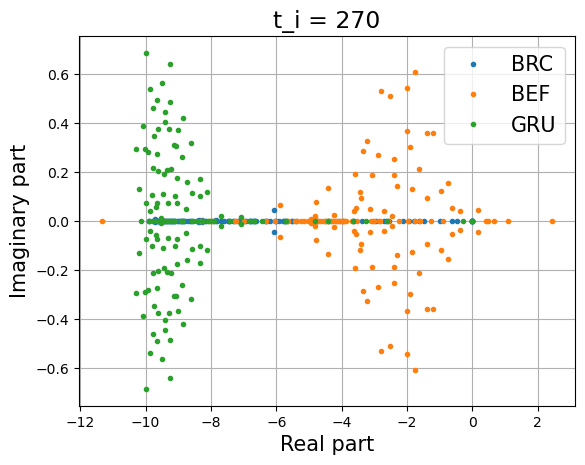

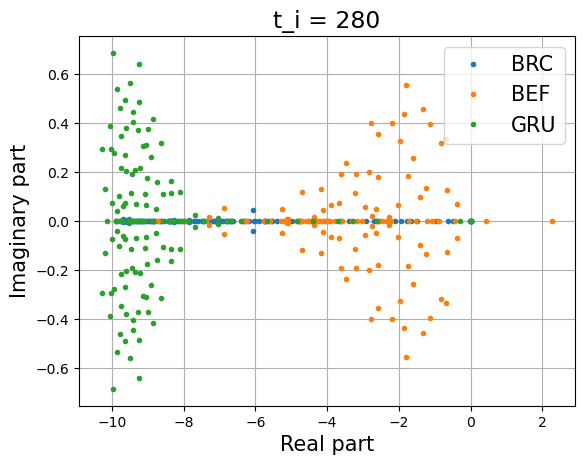

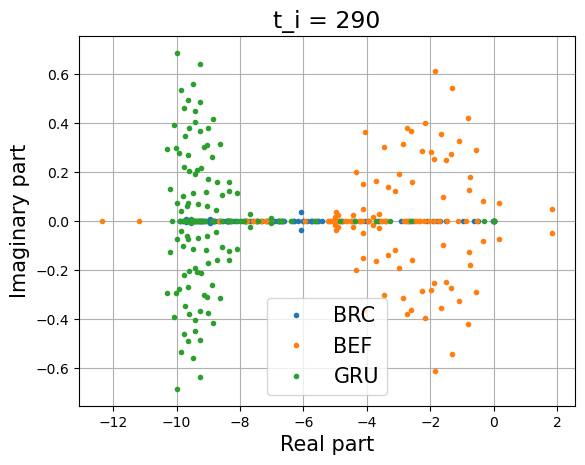

In [324]:
# CHOOSE STATE
for i in range(0,299,10):
    tIDX = i
    x = mod_in[0,tIDX]
    hGRU = GRUmem[0,tIDX]

    hBRC = BRCmem[0,tIDX]

    hfBEF = BEFmemf[0,tIDX]
    hsBEF = BEFmems[0,tIDX]

    # BRC
    def hdotBRC(x,h):
        xin = BRCm.sense(x)
        hnext = BRCm.mem.step(xin.unsqueeze(0),h.unsqueeze(0)).squeeze()
        hdot = (hnext - h)/dt
        return hdot

    JBRC = torch.autograd.functional.jacobian(hdotBRC, (x,hBRC))[1].squeeze()

    eigJ,eigVB = torch.linalg.eig(JBRC)
    # fig, ax = plt.subplots(1,2, figsize = (15,5))
    # ax[0].scatter(range(128),eigJ.real, label = 'BRC')
    # ax[0].grid()

    # ax[1].scatter(range(128),eigJ.imag, label = 'BRC')
    # ax[1].grid()

    plt.plot(eigJ.real, eigJ.imag, '.', label = 'BRC')
    #BEF
    def hdotBEF(x,hf,hs):
        xin = BEFm.sense(x)
        hnext,_ = BEFm.mem.step(xin.unsqueeze(0),hf.unsqueeze(0),hs.unsqueeze(0))
        hnext = hnext.squeeze()
        hdot = (hnext - hf)/dt
        return hdot

    JBEF = torch.autograd.functional.jacobian(hdotBEF, (x,hfBEF,hsBEF))[1].squeeze()

    eigJ,eigVBE = torch.linalg.eig(JBEF)
    # ax[0].scatter(range(128),eigJ.real, label = 'BEF')
    # ax[0].grid()

    # ax[1].scatter(range(128),eigJ.imag, label = 'BEF')
    # ax[1].grid()

    plt.plot(eigJ.real, eigJ.imag, '.', label = 'BEF')
    # GRU
    def hdotGRU(x,h):
        xin = GRUm.sense(x)
        hnext = GRUm.mem(xin[None,:],h[None,:])[0].squeeze()
        hdot = (hnext - h)/dt
        return hdot

    JGRU = torch.autograd.functional.jacobian(hdotGRU, (x,hGRU))[1].squeeze()

    eigJ,eigVG = torch.linalg.eig(JGRU)
    # ax[0].scatter(range(128),eigJ.real, label = 'GRU')
    # ax[0].set_ylabel("Real part", fontsize = 20)

    # ax[1].scatter(range(128),eigJ.imag, label = 'GRU')
    # ax[1].set_ylabel("Imaginary part", fontsize = 20)
    # plt.legend(fontsize = 17)
    # fig.suptitle(f"t_i = {i}", fontsize = 20)
    # ax[0].grid()
    # ax[1].grid()
    # plt.show()

    plt.plot(eigJ.real, eigJ.imag, '.', label = 'GRU')
    plt.legend(fontsize = 15)
    plt.title(f"t_i = {i}", fontsize = 17)
    plt.ylabel("Imaginary part", fontsize = 15)
    plt.xlabel("Real part", fontsize = 15)
    plt.grid()
    plt.show()
